# Neural Style Transfer (NST) VGG16:

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import cv2

### Loading the model

In [2]:
model = models.vgg16(pretrained = True).features
for param in model.parameters():
    param.requires_grad_(False)

c:\Users\sohaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sohaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Data Preprocessing:
- Resizing images: making them in one size.
- Transforming images: tranform images into tensors.
- Normalization.

In [3]:
def load_img(img_path, max_size = 400, shape = None):
    
    image = Image.open(img_path).convert("RGB")
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = transform(image).unsqueeze(0)
    
    return image

In [6]:
content_img = load_img(r'D:\ICS\Year 3\Semester 2\Deep Learning\Project\CW2\dataset\content-images\c3.jpg')
style_img = load_img(r'D:\ICS\Year 3\Semester 2\Deep Learning\Project\CW2\dataset\style-images\s4.jpg', shape = content_img.shape[2:])

In [7]:
content_img.size()

torch.Size([1, 3, 400, 599])

In [8]:
style_img.size()

torch.Size([1, 3, 400, 599])

In [9]:
def im_convert(tensor):
    
    image = tensor.clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

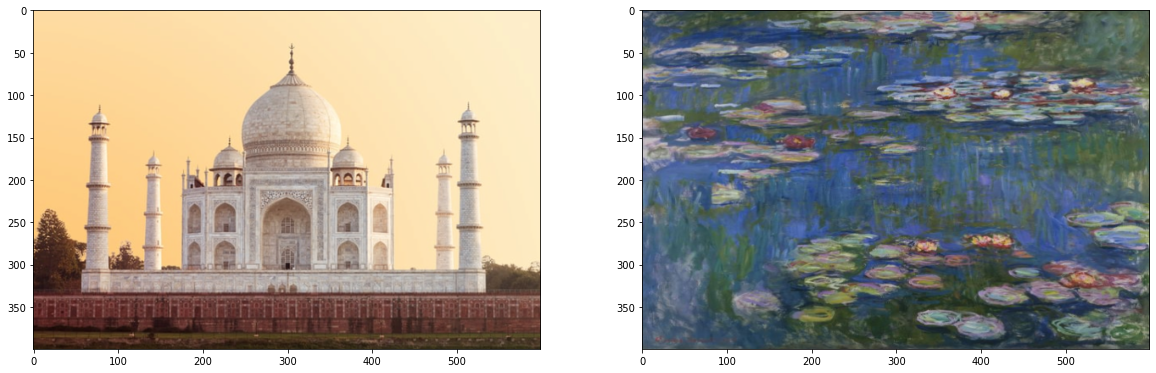

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))

In [11]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': "conv2_1",
                  '10': "conv3_1",
                  '19': "conv4_1",
                  '21': "conv4_2",
                  "28": 'conv5_1'}
        

    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [13]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [14]:
content_features = get_features(content_img, model)
style_features = get_features(style_img, model)
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}
target_1 = content_img.clone().requires_grad_(True)

In [15]:
style_weights = {"conv1_1": 1.,
                  "conv2_1": 0.8,
                  "conv3_1": 0.5,
                  "conv4_1": 0.3,
                  "conv5_1": 0.1}
content_weight = 1
style_weight = 1e6

Total loss 5511768.0


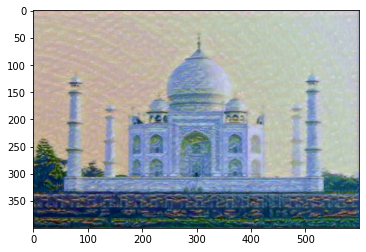

Total loss 3966935.0


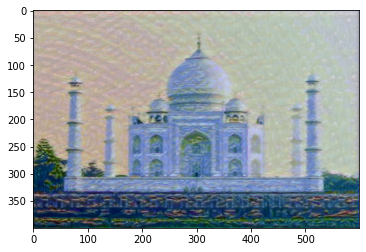

Total loss 2887308.75


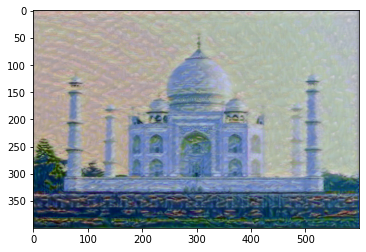

Total loss 2161299.0


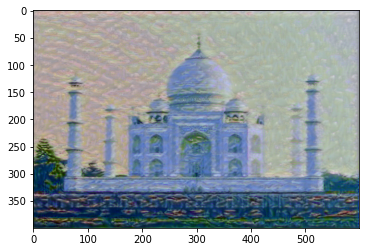

Total loss 1682554.625


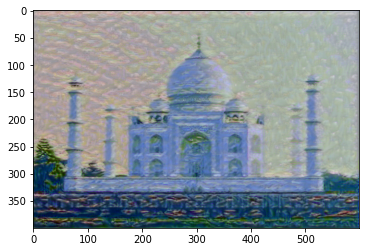

Total loss 1362948.5


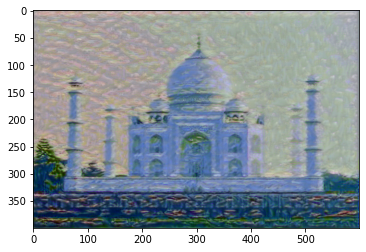

Total loss 1139774.875


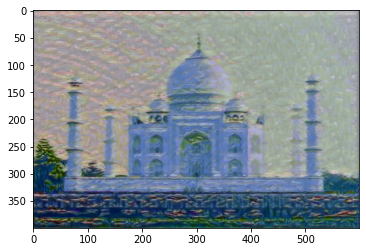

Total loss 973440.5


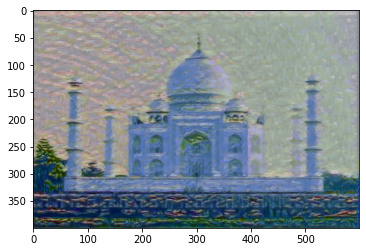

In [20]:
show_every = 50
optimizer = optim.Adam([target_1], lr= 0.005)
steps = 400

for step in range(1, steps+1):
    target_features = get_features(target_1, model)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.size()
        
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss /(d*h*w)
    
    total_loss = (content_weight* content_loss) + (style_weight* style_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % show_every == 0:
        print("Total loss", total_loss.item())
        plt.imshow(im_convert(target_1))
        plt.show()

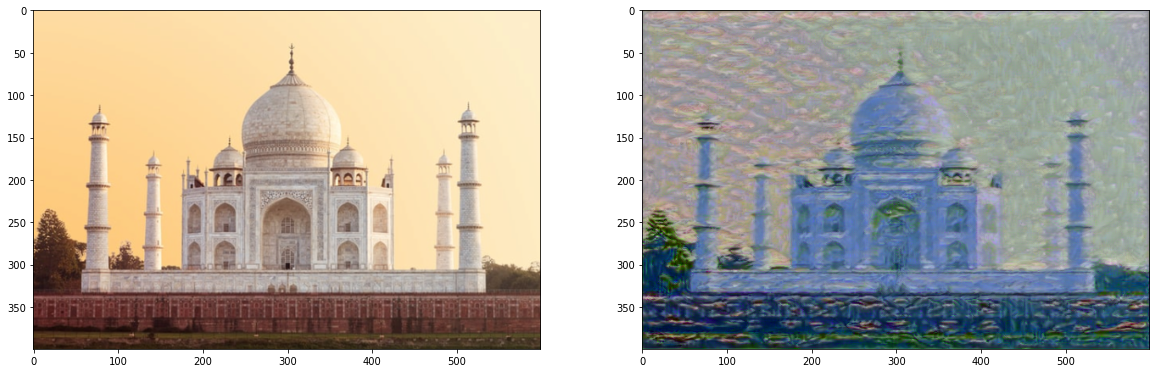

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(target_1))

### Evaluation:

In [ ]:
#TensorBoard
writer = SummaryWriter()

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    content_features = get_features(content_image, vgg16, content_layers)
    style_features = get_features(style_image, vgg16, style_layers)
    generated_features = get_features(generated_image, vgg16, content_layers + style_layers)
    
    # Calculate losses
    c_loss = content_loss(content_features, generated_features)
    s_loss = style_loss(style_features, generated_features)
    t_loss = total_variation_loss(generated_image)
    
    total_loss = c_loss + s_loss + t_loss
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    # Structural Similarity Index (SSIM), and Peak Signal-to-Noise Ratio (PSNR).
    # Calculate SSIM and PSNR
    ssim_score = ssim(content_image[0].cpu().permute(1, 2, 0).numpy(), 
                      generated_image[0].detach().cpu().permute(1, 2, 0).numpy(), 
                      multichannel=True)
    psnr_score = psnr(content_image[0].cpu().permute(1, 2, 0).numpy(), 
                      generated_image[0].detach().cpu().permute(1, 2, 0).numpy())
    
    # Write metrics to TensorBoard
    writer.add_scalar('Content Loss', c_loss.item(), epoch)
    writer.add_scalar('Style Loss', s_loss.item(), epoch)
    writer.add_scalar('Total Variation Loss', t_loss.item(), epoch)
    writer.add_scalar('SSIM', ssim_score, epoch)
    writer.add_scalar('PSNR', psnr_score, epoch)
    
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Total Loss: {total_loss.item()}, SSIM: {ssim_score}, PSNR: {psnr_score}')

writer.close()

Draft:

In [18]:
# # Function to load and preprocess images
# def load_and_preprocess_images(image_paths):
#     images = []
#     for img_path in image_paths:
#         image = Image.open(img_path)
#         image = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
#         images.append(image)
#     return torch.cat(images, dim=0)

In [19]:
# # Load and preprocess content and style images from folders
# content_folder = "D:\ICS\Year 3\Semester 2\Deep Learning\Project\CW2\data\content-images"
# style_folder = "D:\ICS\Year 3\Semester 2\Deep Learning\Project\CW2\data\style-images"

# content_images = [os.path.join(content_folder, img) for img in os.listdir(content_folder)]
# style_images = [os.path.join(style_folder, img) for img in os.listdir(style_folder)]

# content_images = load_and_preprocess_images(content_images)
# style_images = load_and_preprocess_images(style_images)